# Random Forest Algorithm

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_recall_fscore_support
)
from sklearn.preprocessing import LabelEncoder
from scipy.stats import pearsonr

In [2]:
problem_types = ['regression','classification'] #regression or classification
input_types = ["random_forest_elimination","correlation_variance_filter","PCA","Factor_Analysis","genetic_algorithm"] #reduced features: , genetic_algorithm, PCA, Factor_Analysis, random_forest
seed = 254


In [3]:
def read_file(problem_type, input_file, target_file='../../3_train_test_split/descriptors_all.csv'):
    """
    Read input features and recover target values (IC50 or Potency).

    Parameters:
        problem_type (str): 'regression' or 'classification'.
        input_file (str): Path to the input feature file.
        target_file (str): Path to the target descriptor file.

    Returns:
        tuple:
            - X_indexed (pd.DataFrame): Feature DataFrame indexed by 'Molecule ChEMBL ID'.
            - target (pd.Series): Target values indexed by 'Molecule ChEMBL ID'.
    """
    if problem_type not in {'regression', 'classification'}:
        raise ValueError("Invalid problem_type. Must be 'regression' or 'classification'.")

    target_column = '-logIC50' if problem_type == 'regression' else 'Potency'

    # Load features and target data
    X = pd.read_csv(input_file, index_col='Molecule ChEMBL ID')
    target = pd.read_csv(target_file, usecols=['Molecule ChEMBL ID', target_column], index_col='Molecule ChEMBL ID')
    
    # Merge and ensure correct data alignment
    merged = X.join(target, how='inner')

    return merged.drop(columns=target_column), merged[target_column]

In [4]:
def run_random_forest(problem_type, input_type, seed=42):
    """
    Run Random Forest with 5-fold cross-validation and hyperparameter optimization.

    Parameters:
        problem_type (str): 'regression' or 'classification'.
        input_type (str): Feature reduction scheme directory (e.g., 'PCA').
        seed (int): Random seed for reproducibility.

    Returns:
        dict: Best model, test predictions, evaluation metrics, and test dataset.
    """
    # Define base directory lookup
    base_dir = f"../../4_feature_selection/{input_type}/"
    if input_type == "PCA":
        base_dir = os.path.join(base_dir, "PCA_results/PCA_components/")
    elif input_type == "Factor_Analysis":
        base_dir = os.path.join(base_dir, "FA_results/selected_features/")
    elif input_type == "genetic_algorithm":
        base_dir = os.path.join(base_dir, "xgboost/")

    problem = "reg" if problem_type == "regression" else "class"
    train_files = sorted(glob.glob(os.path.join(base_dir, f"train_{problem}_*.csv")))
    val_files = sorted(glob.glob(os.path.join(base_dir, f"val_{problem}_*.csv")))
    test_file = os.path.join(base_dir, f"test_{problem}.csv")

    # Load test data
    X_test, y_test = read_file(problem_type, test_file)

    # Model and scoring
    model = (
        RandomForestRegressor(random_state=seed) if problem_type == "regression"
        else RandomForestClassifier(random_state=seed, class_weight="balanced")
    )
    scoring = "neg_mean_squared_error" if problem_type == "regression" else "accuracy"

    # Define hyperparameter space
    param_distributions = {
        'n_estimators': [100, 200, 500, 1000],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False],
    }

    fold_metrics = []
    best_models = []

    for fold, (train_file, val_file) in enumerate(zip(train_files, val_files), start=1):
        print(f"Processing fold {fold}...")

        # Load train and validation data
        X_train, y_train = read_file(problem_type, train_file)
        X_val, y_val = read_file(problem_type, val_file)

        # Hyperparameter tuning
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_distributions,
            n_iter=50,
            scoring=scoring,
            cv=3,
            n_jobs=-1,
            verbose=1,
            random_state=seed,
        )
        random_search.fit(X_train, y_train)
        best_model = random_search.best_estimator_
        best_models.append(best_model)

        # Evaluate on validation set
        y_val_pred = best_model.predict(X_val)
        metric = (
            mean_squared_error(y_val, y_val_pred) if problem_type == "regression"
            else accuracy_score(y_val, y_val_pred)
        )
        fold_metrics.append(metric)
        print(f"Fold {fold} - Validation Metric: {metric:.4f}")

    # Select the best model based on validation performance
    best_model_idx = np.argmin(fold_metrics) if problem_type == "regression" else np.argmax(fold_metrics)
    final_model = best_models[best_model_idx]

    # Evaluate the best model on the test set
    y_test_pred = final_model.predict(X_test)
    test_metric = (
        mean_squared_error(y_test, y_test_pred) if problem_type == "regression"
        else accuracy_score(y_test, y_test_pred)
    )
    print(f"Test Metric: {test_metric:.4f}")

    return {
        'best_model': final_model,
        'test_predictions': y_test_pred,
        'test_metric': test_metric,
        'X_test': X_test,
        'y_test': y_test,
    }


In [5]:
def evaluate_model(final_model, X_test, y_test, problem_type, input_type, model_type="random_forest"):
    """
    Evaluate the model, create plots, and save performance summary and predictions.

    Parameters:
        final_model: Trained model.
        X_test (pd.DataFrame): Test feature set.
        y_test (pd.Series): True target values for the test set.
        problem_type (str): 'regression' or 'classification'.
        input_type (str): Feature reduction scheme used.
        model_type (str): Model type (default is 'random forest').

    Returns:
        None
    """
    # Generate file prefix
    file_prefix = f"{model_type}_{problem_type}_{input_type}"

    # Predictions
    y_pred = final_model.predict(X_test)

    if problem_type == "regression":
        # Calculate regression metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        pearson_corr, _ = pearsonr(y_test, y_pred)

        # Save performance summary
        performance_summary = pd.DataFrame([{
            "model_type": model_type,
            "problem_type": problem_type,
            "input_type": input_type,
            "mse": mse,
            "r2_score": r2,
            "pearson_corr": pearson_corr
        }])
        performance_summary.to_csv(f"{file_prefix}_performance_summary.csv", index=False)

        # Save predictions
        predictions = pd.DataFrame({
            "Molecule ChEMBL ID": X_test.index,
            "True IC50": y_test,
            "Predicted IC50": y_pred
        })
        predictions.to_csv(f"{file_prefix}_predictions.csv", index=False)

        # Plot Predicted vs Target
        plt.figure(figsize=(6, 6), dpi=150)
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
        plt.xlabel("True IC50")
        plt.ylabel("Predicted IC50")
        plt.title("Predicted vs True")
        plt.savefig(f"{file_prefix}_predicted_vs_true.png")
        plt.show()

        # Plot Residuals
        residuals = y_test - y_pred
        plt.figure(figsize=(6, 6), dpi=150)
        sns.scatterplot(x=y_test, y=residuals, alpha=0.7)
        plt.axhline(0, color="red", linestyle="--")
        plt.xlabel("True IC50")
        plt.ylabel("Residuals")
        plt.title("Residual Plot")
        plt.savefig(f"{file_prefix}_residuals.png")
        plt.show()

    elif problem_type == "classification":
        # Calculate classification metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")

        # Save performance summary
        performance_summary = pd.DataFrame([{
            "model_type": model_type,
            "problem_type": problem_type,
            "input_type": input_type,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        }])
        performance_summary.to_csv(f"{file_prefix}_performance_summary.csv", index=False)

        # Save predictions
        predictions = pd.DataFrame({
            "Molecule ChEMBL ID": X_test.index,
            "True Potency": y_test,
            "Predicted Potency": y_pred
        })
        predictions.to_csv(f"{file_prefix}_predictions.csv", index=False)

        # Plot Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
        disp.plot(cmap="Blues", values_format="d")
        plt.title("Confusion Matrix")
        plt.savefig(f"{file_prefix}_confusion_matrix.png")
        plt.show()

        # Plot ROC Curve
        if hasattr(final_model, "predict_proba"):
            y_proba = final_model.predict_proba(X_test)
            plt.figure(figsize=(8, 6), dpi=150)
            for i, class_label in enumerate(final_model.classes_):
                fpr, tpr, _ = roc_curve((y_test == class_label).astype(int), y_proba[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f"{class_label} (AUC = {roc_auc:.2f})")
            plt.plot([0, 1], [0, 1], color="red", linestyle="--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve (One-vs-Rest)")
            plt.legend()
            plt.savefig(f"{file_prefix}_roc_curve.png")
            plt.show()

## Train and Evaluate the Model

Training Random Forest model for regression using random_forest_elimination features...
Processing fold 1...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fold 1 - Validation Metric: 3.2444
Processing fold 2...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fold 2 - Validation Metric: 2.8758
Processing fold 3...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fold 3 - Validation Metric: 3.4307
Processing fold 4...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fold 4 - Validation Metric: 3.4791
Processing fold 5...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fold 5 - Validation Metric: 4.0124
Test Metric: 3.1671
Evaluating the model...


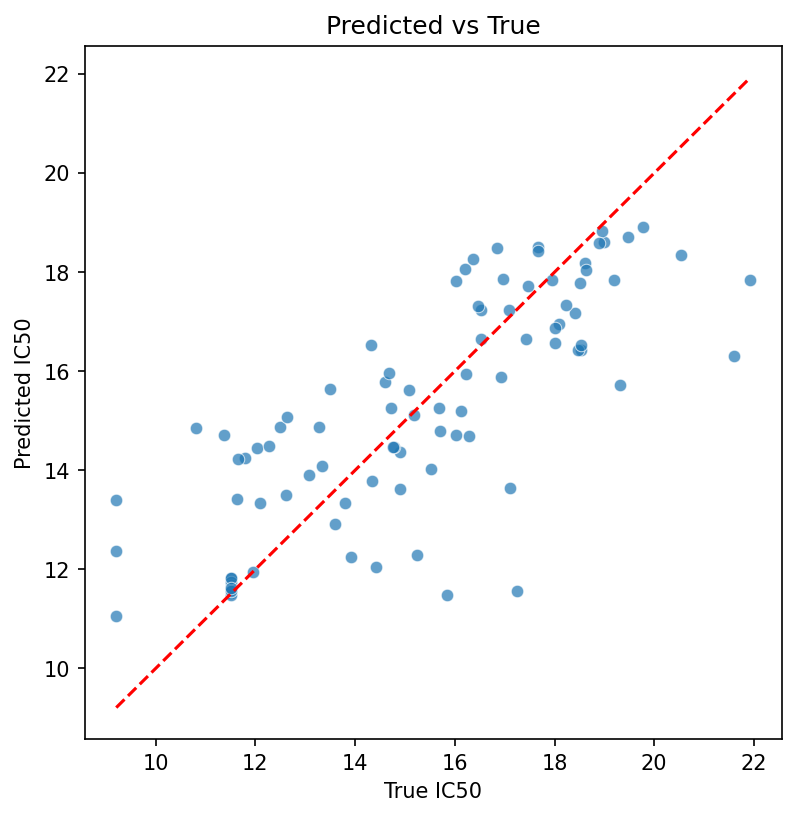

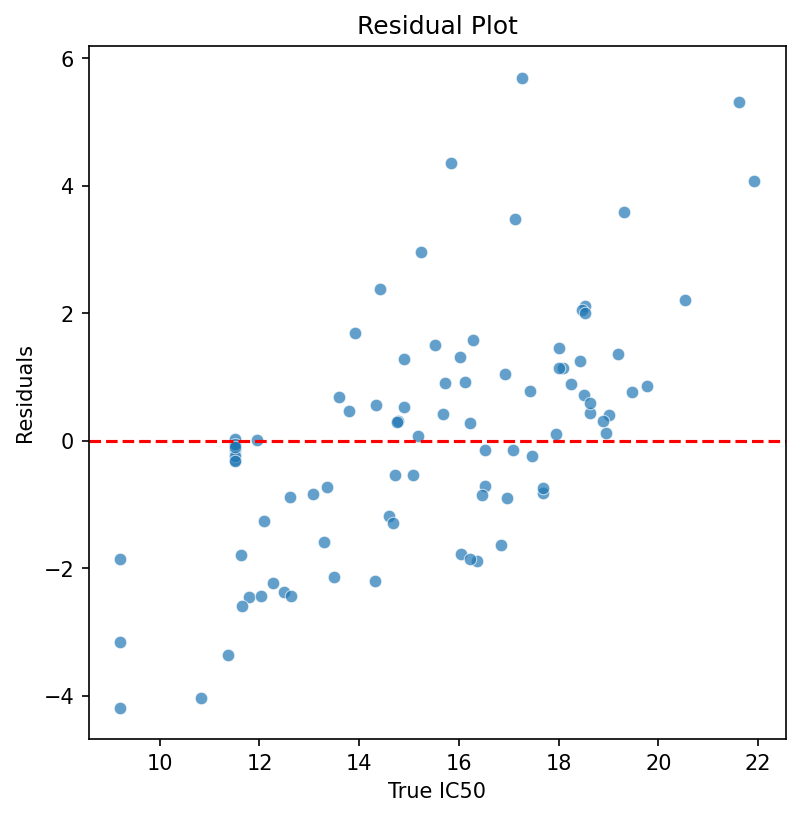

Training and evaluation complete
Training Random Forest model for classification using random_forest_elimination features...
Processing fold 1...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fold 1 - Validation Metric: 0.8571
Processing fold 2...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fold 2 - Validation Metric: 0.7905
Processing fold 3...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fold 3 - Validation Metric: 0.7619
Processing fold 4...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fold 4 - Validation Metric: 0.7981
Processing fold 5...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fold 5 - Validation Metric: 0.7981
Test Metric: 0.7939
Evaluating the model...


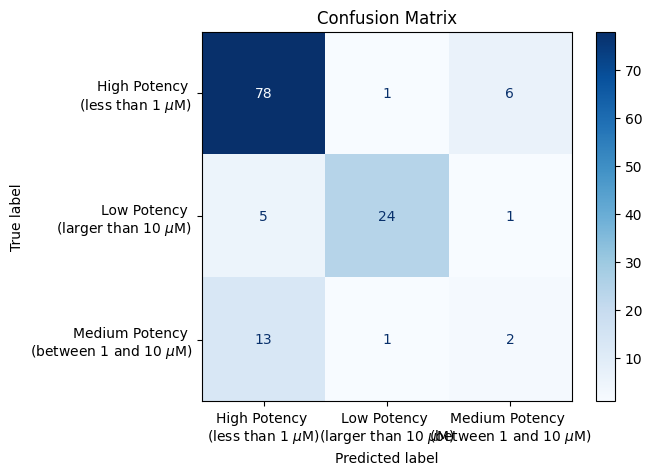

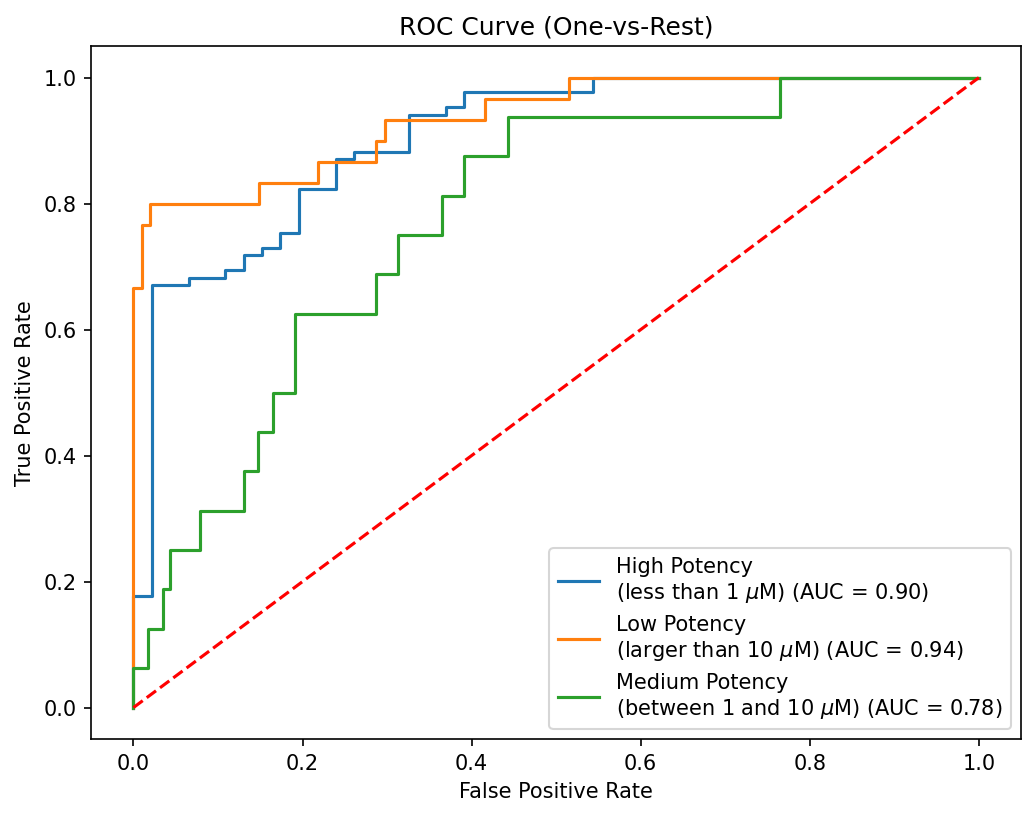

Training and evaluation complete
Training Random Forest model for regression using correlation_variance_filter features...
Processing fold 1...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [ ]:
for input_type in input_types:
    for problem_type in problem_types:
        print(f"Training Random Forest model for {problem_type} using {input_type} features...")
        results = run_random_forest(problem_type=problem_type, input_type=input_type, seed=seed)
        
        # Unpack results
        final_model = results["best_model"]
        X_test = results["X_test"]
        y_test = results["y_test"]
        
        # Evaluate the model
        print(f"Evaluating the model...")
        evaluate_model(final_model, X_test, y_test, problem_type, input_type, "random_forest")
        
        print("Training and evaluation complete")
